### 목표
- 버섯의 특징을 활용해 독성/식용 버섯을 분류하는 실습을 해보자
- DesitionTree 분류 모델을 학습하고 시각화 & 과대적합 제어
- 모델 자체적으로 특성 중요도 선택한 것을 확인해보기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier  # 트리 분류 모델

In [2]:
# mushroom.csv 데이터 불러오기
# data라는 변수 안에 넣기
data = pd.read_csv('./data/mushroom.csv')
data.head(3)
# poisonous -> 답데이터  // p - 독버섯 , e - 식용버섯
# poisonous를 제외한 나머지 컬럼 -> 문제데이터
data.info()  # 컬럼이름, 행열크기, 결측치여부, 데이터타입
# Dtype (object) : 파이썬에서는 대체로 문자열을 나타냄

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   poisonous                 8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [3]:
data.head(1)
# df의 컬럼 모두 출력하기 -> 생략 안하기
pd.set_option('display.max_columns', None)  # 데이터프레임의 모든 컬럼이 생략없이 출력
data.head(1)
# 데이터 타입 : 문자열
# 머신러닝 모델은 수치화된 데이터만 학습이 가능
# 문자 -> 수치화 : encoding

,poisonous,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u


### 데이터 전처리 및 탐색
 - 문제(특성)와 답(라벨) 분리

In [4]:
data

,poisonous,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,e,?,s,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,t,?,s,k,w,w,p,w,o,e,w,v,l


In [5]:
# 컬럼 인덱싱
# 답 : poisonous , 문제는 poisonous를 제외한 모든 컬럼
X = data.drop('poisonous', axis = 1)
# X = data.iloc[:,1:]
y = data['poisonous']

# 크기 확인
print('문제 크기:', X.shape)
print('답 크기:', y.shape)

문제 크기: (8124, 22)
답 크기: (8124,)


In [6]:
# 문제데이터 기술통계 확인하기
# 최소, 최대, 평균, 중앙, 최빈값 ...
# 문자형태(범주형) -> 최빈값만 제공
X.describe()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [7]:
# 독성, 식용 버섯이 답데이터에 각각 몇 개씩 들어있을까?
y.value_counts()

poisonous
e    4208
p    3916
Name: count, dtype: int64

- 인코딩(encoding) : 범주(문자) -> 수치화
    - 레이블 인코딩(label encoding) : 값의 크고 작음에 의미가 있는 경우
    - 원핫 인코딩(one-hot encoding) : 값의 크고 작음에 의미가 없는 경우

In [8]:
# 버섯 데이터의 모든 컬럼을 원핫인코딩
# pd.get_dummies(대상) : 원핫인코딩 함수
X_oh = pd.get_dummies(X)
X_oh.head(1)
# 크기 확인
X_oh.shape

(8124, 117)

In [9]:
# 훈련세트, 테스트세트 분리
# 분리 비율 7:3
# 랜덤 섞기 고정값 3
X_train, X_test, y_train, y_test = train_test_split(X_oh, y,
                                    test_size = 0.3, random_state = 3)
# 크기 확인
print('훈련 문제:' , X_train.shape)
print('훈련 답:', y_train.shape)
print('테스트 문제:', X_test.shape)
print('테스트 답:', y_test.shape)

훈련 문제: (5686, 117)
훈련 답: (5686,)
테스트 문제: (2438, 117)
테스트 답: (2438,)


#### 모델링
- tree 모델 객체 생성
- 학습

In [10]:
tree_model = DecisionTreeClassifier(max_depth=3)  # 기본값 그대로 사용
# -> 트리 모델이 가지를 뻗어나갈 수 있을만큼 최대로 뻗어나감
# 모델이 깊어지는 현상
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

- 모델의 일반화 성능 확인 : 교차검증
    - 개념 : 일반화 성능 측정 방법 -> 모든 데이터에 대해 모델이 얼마나 잘 맞추는지 평가, 한 번 나누는 것보다는 더 안정적인 방법
    - 방법론 : 훈련세트를 기준으로 훈련세트와 검증용 세트로 여러겹 나눠서 평가(새로운 test 데이터를 train세트 내부에서 여러 개 만들어서 평가)
    - 모델을 정의하고 학습하기 전에 정확도가 어느 정도일지 확인하는 것이 가능

In [11]:
# 교차검증 라이브러리 불러오기
from sklearn.model_selection import cross_val_score

In [12]:
# cross_val_score(모델명, 훈련문제, 훈련답,
#                 cv = 검증횟수(검증 데이터를 분리하는 횟수))
result1 = cross_val_score(tree_model, X_train, y_train, cv = 5)
result1
# 해당 모델은 버섯 분류에 있어서 과대적합을 제어하지 않아도
# 성능이 상당히 좋은 상태!
# 과대적합 제어할 필요가 X

array([0.98506151, 0.9876869 , 0.98504837, 0.98328936, 0.9876869 ])

In [13]:
# X_test 성능 확인
# predict -> 실제값과 비교
# accuracy_score(실제값, 예측값)  --> 예측값이 무조건 존재해야만 함
# 모델이 자체적으로 가지고 있는 score() -> 정확도
test_acc = tree_model.score(X_test, y_test) # -> 정확도
test_acc   # 100% 맞춘상태
# 버섯 특징데이터는 버섯을 잘 분류하기에 굉장히 좋은 데이터!!

0.9840032813781788

### 모델이 선택한 중요한 특성 확인
 - 특성 선택
 - tree 계열의 모델은 특성 중요도를 출력하는 키워드가 있다
 - 모델이름.feature_importances_

In [14]:
X_oh.columns

Index(['cap-shape_b', 'cap-shape_c', 'cap-shape_f', 'cap-shape_k',
       'cap-shape_s', 'cap-shape_x', 'cap-surface_f', 'cap-surface_g',
       'cap-surface_s', 'cap-surface_y',
       ...
       'population_s', 'population_v', 'population_y', 'habitat_d',
       'habitat_g', 'habitat_l', 'habitat_m', 'habitat_p', 'habitat_u',
       'habitat_w'],
      dtype='object', length=117)

In [15]:
fi = tree_model.feature_importances_
fi  # 과학적표기법 -> 실수값(지수표현방식)
# df로 변환
fi_df = pd.DataFrame(fi, index = X_oh.columns,
                     columns = ['import']) # 117개의 특성 중요도 수치값
fi_df

# 특성 중요도 내림차순 정렬해보기 (top5)
fi_df['import'].sort_values(ascending= False).head()
# odor_n : 냄새

odor_n                 0.651303
stalk-root_c           0.185905
stalk-root_r           0.094922
spore-print-color_r    0.034740
odor_m                 0.016734
Name: import, dtype: float64

#### tree 모델 시각화
- 시각화 패키지(graphviz) 설치
- anaconda prompt 실행 후 pip install graphviz > jupyter 노트북 내부 !pip install graphviz

In [16]:
!pip install graphviz

Active code page: 65001


In [17]:
# jupyter 노트북 껐다가 다시 실행해서 run all -> 라이브러리 불러오기
from sklearn.tree import export_graphviz
export_graphviz(tree_model, out_file = './data/tree.dot',
                class_names = ['독', '식'],
                feature_names = X_oh.columns,
                impurity = False,  # 지니불순도와 비슷한 개념을 가진 속성
                filled = True)  # 해당 노드의 클래스에 대한 색상 지정

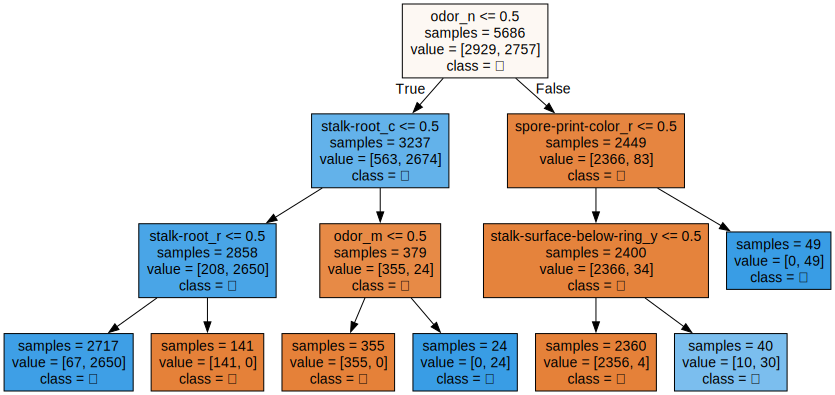

In [18]:
import graphviz
# tree.dot 파일 열어주기
with open('./data/tree.dot', encoding = 'UTF8') as f:  # 외부에 있는 파일을 읽어주는 코드
    # 파일이 열려있다
    dot_graph = f.read()
dot_graph
# 그래프 그려보기
display(graphviz.Source(dot_graph))

In [19]:
import os
os.environ["PATH"]+=os.pathsep+'C:/Program Files/Graphviz/bin/'